<a href="https://colab.research.google.com/github/butyusya/tests/blob/main/Math_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from statistics import mean
from collections import defaultdict as dd

In [195]:
def info_by_graph(G, min: int, max: int) -> tuple[dict, dict, dict]:
  edges = list(G.edges())
  connections = dd(list)
  for edge in edges:
    connections[edge[0]].append(edge[1])
    connections[edge[1]].append(edge[0])
  cities = list(G.nodes())
  population = dict()
  illness = dict()
  for city in cities:
    population[city] = random.randint(min, max)
    illness[city] = 0
  illness[random.choice(list(connections.keys()))] = 1
  return connections, population, illness

In [154]:
def add_ill(total: int, ill: int, new: int) -> int:
  if ill + new > total:
    return total
  else:
    return ill + new

In [155]:
def get_number(connections: dict, illness: dict, city: str) -> int:
  if illness[city] == 0:
    return 0
  else:
    neighbors = connections[city]
    ill_near = sum(illness[neighbor] for neighbor in neighbors)
    if ill_near > 0:
      return 2
    else:
      return 1

In [156]:
def spread_inside(connections: dict, population: dict, illness: dict) -> dict:
  for city in connections.keys():
    illness[city] = add_ill(population[city], illness[city],
                            get_number(connections, illness, city))
  return illness

In [157]:
def half(number: int) -> int:
  if number % 2 == 0:
    return number // 2
  elif number == 1:
    return 1
  else:
    return (number + random.randint(0, 1)) // 2

In [158]:
def halved_spread(connections: dict, population: dict,
                  illness: dict) -> tuple[dict, dict]:
  spread = []
  halved_cities = 0
  for city in connections.keys():
    if illness[city] > (population[city] / 2):
      halved_cities += 1
      dead = half(illness[city])
      illness[city] -= dead
      population[city] -= dead
      not_full_neighbors = []
      for neighbor in connections[city]:
        if population[neighbor] != illness[neighbor]:
          not_full_neighbors.append(neighbor)
      if len(not_full_neighbors) > 0:
        spread.append(random.choice(not_full_neighbors))
  if halved_cities == 0:
    return population, illness
  else:
    for city in spread:
      illness[city] = add_ill(population[city], illness[city], 1)
    return halved_spread(connections, population, illness)

In [159]:
def step_forward(connections: dict, population: dict, illness: dict,
                 step: int) -> tuple[dict, dict]:
  for i in range(step):
    illness = spread_inside(connections, population, illness)
    population, illness = halved_spread(connections, population, illness)

  return population, illness

In [160]:
def find_end(connections: dict, population: dict, illness: dict) -> int:
  ill_copy = illness.copy()
  pop_copy = population.copy()
  steps = 0
  while sum(ill[1] for ill in ill_copy.items()) != 0:
    ill_copy = spread_inside(connections, pop_copy, ill_copy)
    pop_copy, ill_copy = halved_spread(connections, pop_copy, ill_copy)
    steps += 1
  return steps

In [161]:
def find_end_mean(connections: dict, population: dict, illness: dict) -> int:
  return mean([find_end(connections, population, illness) for i in range(1000)])

In [235]:
def draw_forward(connections: dict, population: dict, illness: dict, step: int):
  global day
  day += step
  font1 = {'family':'serif','size':36}

  population, illness = step_forward(connections, population, illness, step)
  colors = [plt.cm.RdYlGn(1 - illness[city] / population[city])
            if (population[city] != 0) else 'gray' for city in illness.keys()]
  sizes = [population[city] / max * 1000 if (population[city] != 0)
            else 30 for city in population.keys()]
  fig, ax = plt.subplots(1, figsize=(30, 10))
  plt.axis('off')
  plt.title(f"Day {day}", fontdict = font1)
  nx.draw_networkx(G, ax=ax, with_labels=True, pos=nx.kamada_kawai_layout(G),
          node_color=colors, node_size=sizes, font_size=20, font_family='serif')
  plt.show()

In [236]:
G = nx.connected_watts_strogatz_graph(30, 5, 0.5)
min, max = 100, 100
connections, population, illness = info_by_graph(G, min, max)
day = 1

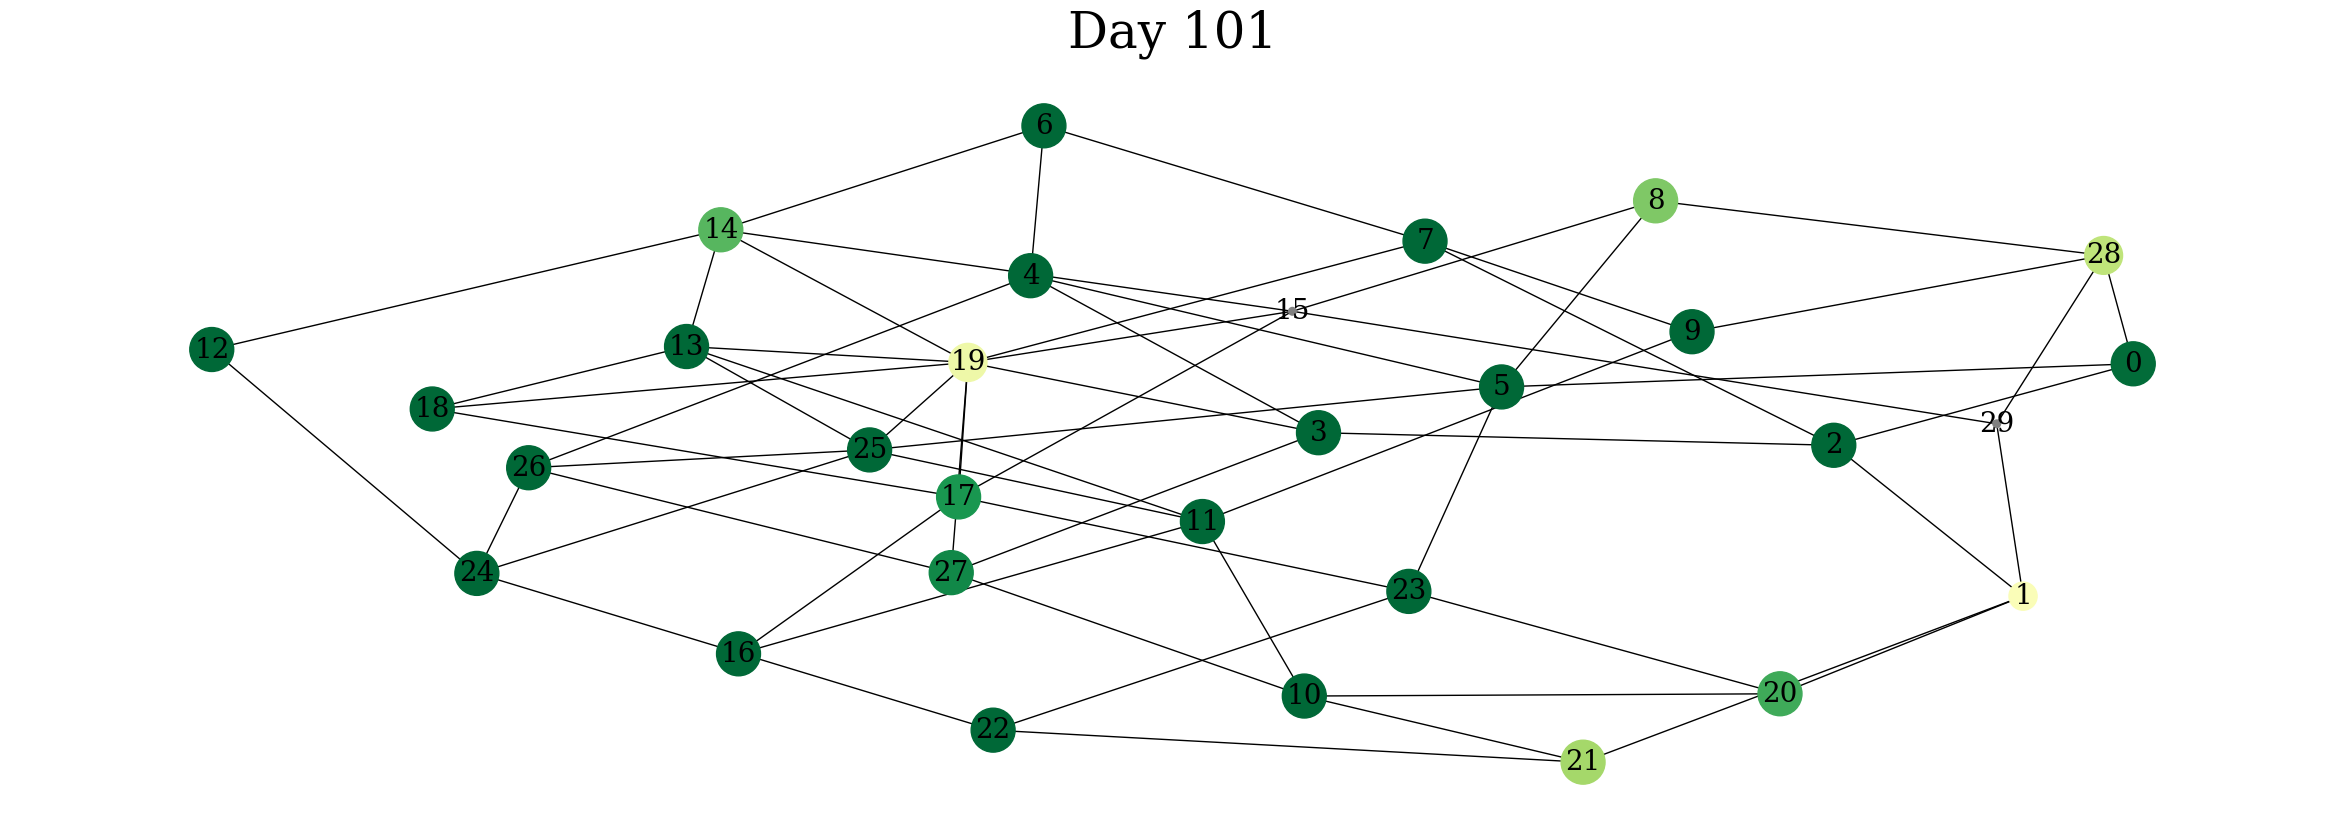

In [237]:
draw_forward(connections, population, illness, 100)